In [2]:
# import dependencies
import os
import numpy as np
import  pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import pathlib
import random
import warnings
import cv2
from tensorflow.keras import backend as K
import tensorflow_hub as hub
warnings.filterwarnings("ignore")

In [3]:
# data directories
datadir = "data/"

In [4]:
os.listdir(datadir)

['magnesium deficiency',
 'multiple',
 'potassium deficiency',
 'herbicide burn',
 'fall army worm',
 'maize streak',
 'sulphur deficiency',
 'healthy',
 'zinc deficiency',
 'stalk borer',
 'nitrogen deficiency']

In [5]:
dataroot = pathlib.Path(datadir)
all_images = dataroot.glob("*/*")
all_images = [str(path) for path in all_images]

In [6]:
all_image_paths = []
for i in all_images:
    if i == 'data/fall army worm/.ipynb_checkpoints':
        del i
    else:
        all_image_paths.append(i)

In [7]:
image_count = len(all_images)
image_count

865

In [11]:
img = plt.imread(random.choice(all_images))
img.shape

(300, 300, 3)

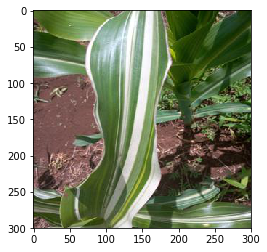

In [12]:
plt.imshow(img)

In [8]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(datadir)
    return image_rel

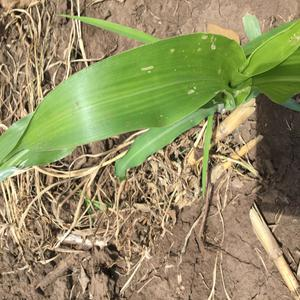

fall army worm\IMG_1123.JPG



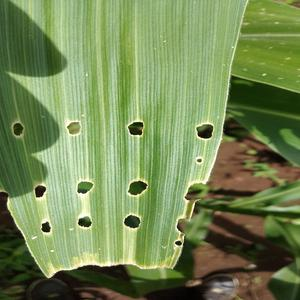

stalk borer\IMG20190523130147.jpg



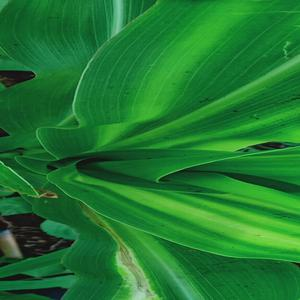

zinc deficiency\IMG20190523133206.jpg



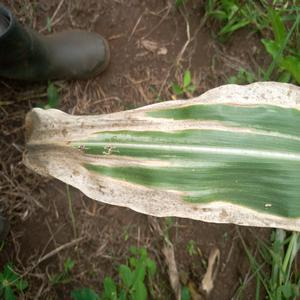

potassium deficiency\IMG_20190523_140519_2.jpg



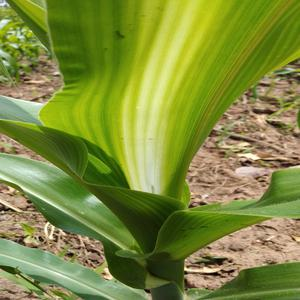

zinc deficiency\IMG20190523121147.jpg



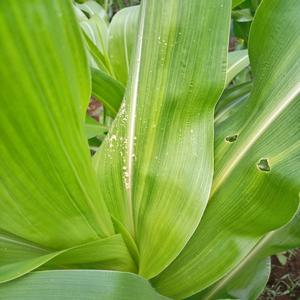

multiple\IMG_20190523_130053_4.jpg



In [9]:
for n in range(6):
    image_path = random.choice(all_images)
    display.display(display.Image(image_path))
    print(caption_image(image_path))
    print()

In [8]:
label_names = sorted(item.name for item in dataroot.glob('*/') if item.is_dir())
label_names

['fall army worm',
 'healthy',
 'herbicide burn',
 'magnesium deficiency',
 'maize streak',
 'multiple',
 'nitrogen deficiency',
 'potassium deficiency',
 'stalk borer',
 'sulphur deficiency',
 'zinc deficiency']

In [9]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'fall army worm': 0,
 'healthy': 1,
 'herbicide burn': 2,
 'magnesium deficiency': 3,
 'maize streak': 4,
 'multiple': 5,
 'nitrogen deficiency': 6,
 'potassium deficiency': 7,
 'stalk borer': 8,
 'sulphur deficiency': 9,
 'zinc deficiency': 10}

In [10]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [3, 3, 3, 3, 3, 3, 3, 5, 5, 5]


In [11]:
# load images
image_array = []
for i in all_image_paths:
    img = cv2.imread(i)
    img_array = cv2.resize(img,(224,224),3)
    image_array.append(img_array)

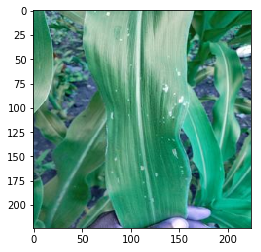

In [12]:
plt.imshow(image_array[30])

In [57]:
# loading images
datagen = ImageDataGenerator(horizontal_flip=True,rotation_range=0.5,rescale=1/255.0)

# Training with Hub keras

In [13]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/3" #@param {type:"string"}

In [14]:
def feature_extractor(x):
    feature_extractor_module = hub.Module(feature_extractor_url)
    return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

Instructions for updating:
Colocations handled automatically by placer.


W0622 21:08:08.164442 140274936026944 deprecation.py:323] From /home/ailead/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [69]:
IMAGE_SIZE

[224, 224]

In [58]:
image_data = datagen.flow(image_array, target)

TypeError: flow() got an unexpected keyword argument 'target_size'

In [15]:
features_extractor_layer = tf.keras.layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

In [16]:
features_extractor_layer.trainable = False

In [17]:
model = tf.keras.Sequential([
  features_extractor_layer,
  tf.keras.layers.Dense(11, activation='softmax')
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0622 21:08:35.357604 140274936026944 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                11022     
Total params: 11,022
Trainable params: 11,022
Non-trainable params: 0
_________________________________________________________________


In [18]:
sess = K.get_session()
init = tf.global_variables_initializer()

In [19]:
init = tf.global_variables_initializer()
sess.run(init)

In [20]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(), 
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [21]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])

In [94]:
for image_batch, label_batch in image_data:
    print(label_batch.shape)
    break

NameError: name 'image_data' is not defined

In [22]:
array = np.array(image_array)

In [50]:
train_x=np.array(image_array)

In [52]:
train_x=np.array(image_array)
train_y=np.array((all_image_labels).flatten)

AttributeError: 'list' object has no attribute 'flatten'

In [49]:
steps_per_epoch = len(image_array)//32
batch_stats = CollectBatchStats()
model.fit(train_x,y = train_y,epochs=9, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats],batch_size=32)

Epoch 1/9


ResourceExhaustedError: OOM when allocating tensor with shape[864,224,224,3] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node lambda/module_1_apply_default/hub_input/Mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [40]:
model.save("maize_image_model.h5")

In [107]:
image_paths = all_images[860:870]

In [108]:
image_paths

['..\\classification\\zinc deficiency\\IMG_20190523_133529_3.jpg',
 '..\\classification\\zinc deficiency\\IMG_20190523_133530_2.jpg',
 '..\\classification\\zinc deficiency\\IMG_20190523_135627_6.jpg',
 '..\\classification\\zinc deficiency\\IMG_20190523_140051_0.jpg',
 '..\\classification\\zinc deficiency\\IMG_20190523_140051_7.jpg',
 '..\\classification\\zinc deficiency\\IMG_20190523_142108_8.jpg']

In [109]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [110]:
images = []

In [111]:
for file in image_paths:
    image = load_img(file)
    image = img_to_array(image)
    images.append(image)

In [112]:
new_images = []

In [113]:
for img in images:
    new = np.resize(img,(224,224,3) )
    new_images.append(new)

In [114]:
new_images[0].shape

(224, 224, 3)

In [115]:
new_images = np.array(new_images)

In [116]:
predictions = model.predict_classes(new_images)

In [117]:
predictions[5]

4